In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

sns.set_style('whitegrid')
cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=["Date"])
ta = pd.read_csv("data/TA_1d.csv", index_col="Date", parse_dates=["Date"])
tp = pd.read_csv("data/TP_1d.csv", index_col="Date", parse_dates=["Date"])

cf = cf[["FR"]]
ta = ta.loc[:, ta.columns.str.startswith("FR")]
tp = tp.loc[:, tp.columns.str.startswith("FR")]
data = pd.concat([ta.mean(axis=1).rename("TA"),
                  tp.mean(axis=1).rename("TP"),
                  cf["FR"].rename("CF")], axis=1)
# Features & Target
X = data.drop(columns="CF")
y = data["CF"]

#ajout d'une fenêtre
X_days_TP = X["TP"].rolling(window=14, min_periods=1).sum() #Somme cumulée des précipitations sur 7 jours 
X_days_TA = X["TA"].rolling(window=90, min_periods=1).mean()#Moyenne sur 90 jours de la température
X_days_TP = X_days_TP.reset_index(drop=True)
X_days_TA = X_days_TA.reset_index(drop=True)

#ajout des saisons
cos = [np.cos(2*np.pi*(t/365)) for t in range(3285)]
sin = [np.sin(2*np.pi*(t/365)) for t in range(3285)]
Saison = pd.DataFrame([[x,y] for x, y in zip(cos,sin)], columns = [5,6])

#Création du tableau
X2 = pd.concat([X_days_TP, X_days_TA], axis = 1)

# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=365, shuffle=False)

#Normalisation
scaler = StandardScaler().set_output(transform="pandas")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.concat([X_train_std, Saison[:][:2920]], axis=1)
X_test_std = pd.concat([X_test_std, Saison[:][2920:]], axis=1)

results = {"Actual": y_test}

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# Récupérer les années disponibles
années = range(2015, 2023)  # 2015 à 2022 pour training/ test progressif 
année_finale = 2023           # année de validation 

splits = [] #Contiendra tous les splits. 

for année_fin_training in years: #L'année finale change, d'abord 2016, puis 2017,...
    # Training : de 2015 jusqu'à l'année_fin_training
    train_idx = data.index[data.index.year <= année_fin_training]
    # Test : l'année suivante
    test_idx = data.index[data.index.year == année_fin_training + 1]
    splits.append((train_idx, test_idx))

# Split final pour garder 2023 en validation
train_final = data.index[data.index.year <= 2022]
test_final = data.index[data.index.year == 2023]


for i, (train, test) in enumerate(splits[:3]):  # afficher les 3 premiers splits
    print(f"Split {i+1}: train {train[0]}-{train[-1]}, test {test[0]}-{test[-1]}")

print(f"\nValidation finale: train {train_final[0]}-{train_final[-1]}, test {test_final[0]}-{test_final[-1]}")
# Exemple pour le dernier split (2023 en validation)
X_train = X.loc[train_final]
y_train = y.loc[train_final]
X_test = X.loc[test_final]
y_test = y.loc[test_final]

print(X_train.shape, X_test.shape)


NameError: name 'years' is not defined

Split 1: Train=365, Test=365, MSE=0.0066, R2=0.3924
R2: 0.437749
MSE: 0.012470



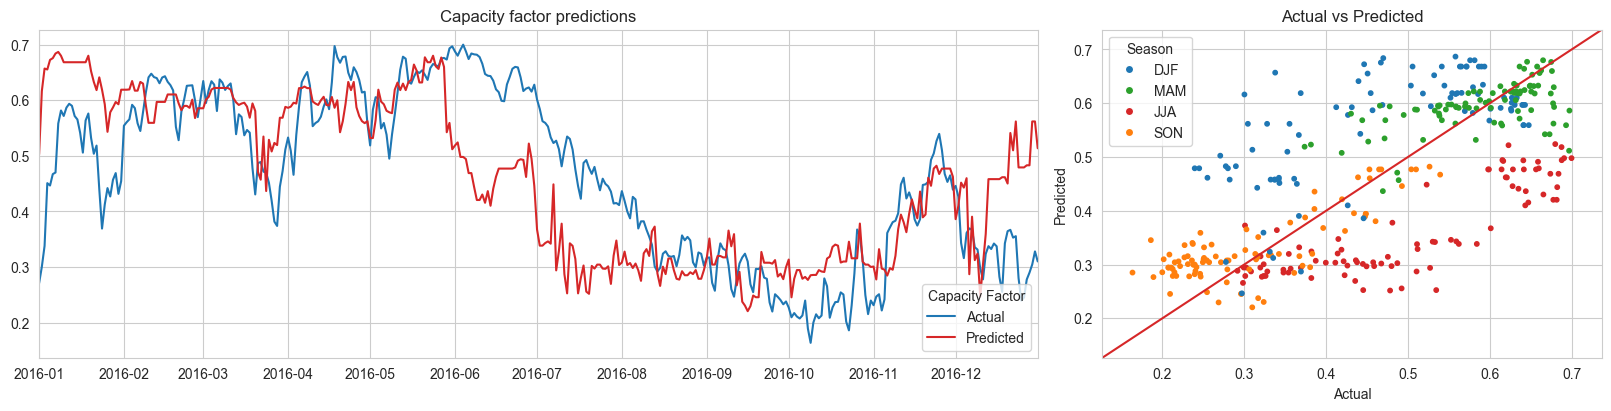

Split 2: Train=730, Test=365, MSE=0.0125, R2=0.4377
R2: 0.172585
MSE: 0.010669



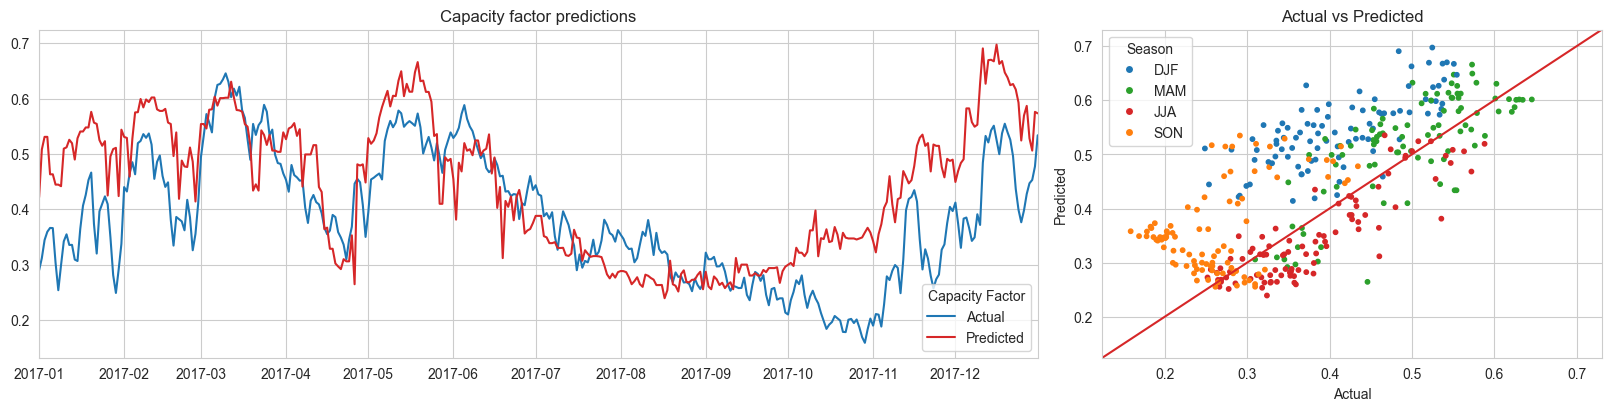

Split 3: Train=1095, Test=365, MSE=0.0107, R2=0.1726
R2: 0.586292
MSE: 0.010878



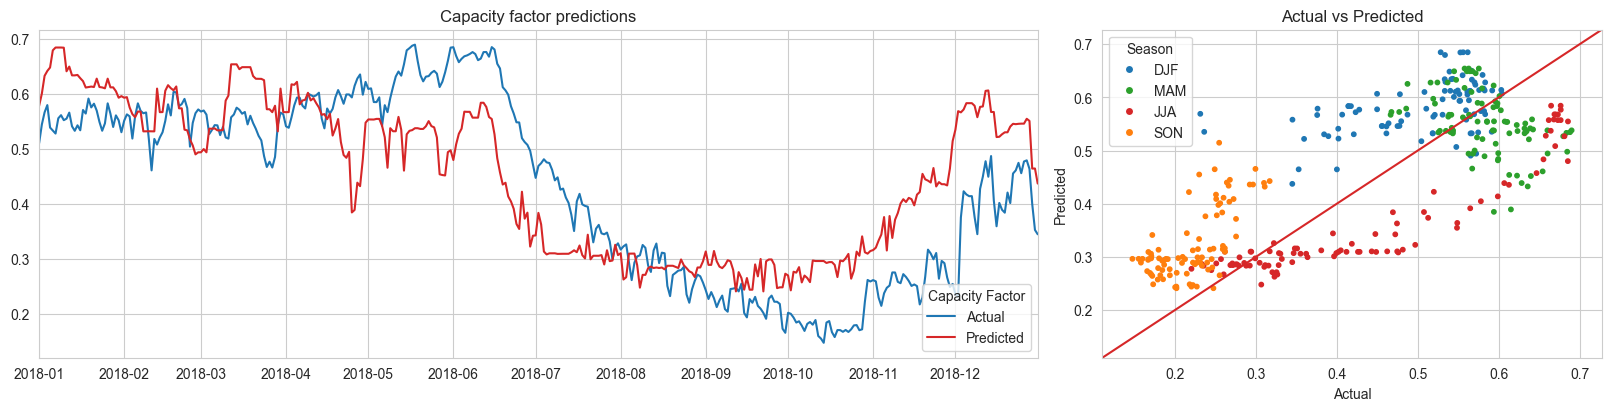

Split 4: Train=1460, Test=365, MSE=0.0109, R2=0.5863
R2: 0.528003
MSE: 0.006223



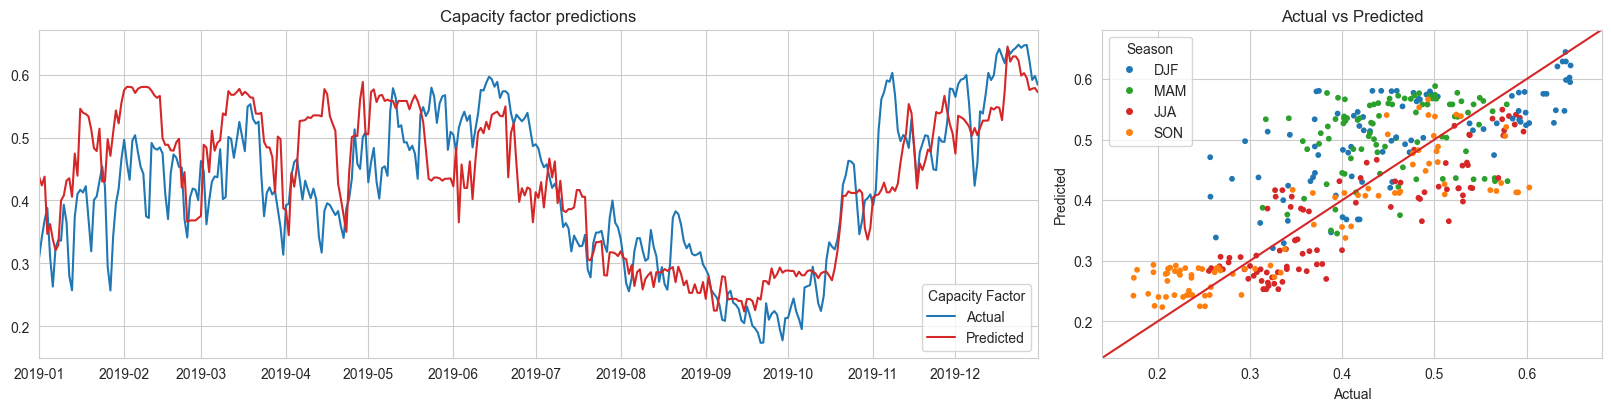

Split 5: Train=1825, Test=365, MSE=0.0062, R2=0.5280
R2: 0.562943
MSE: 0.004563



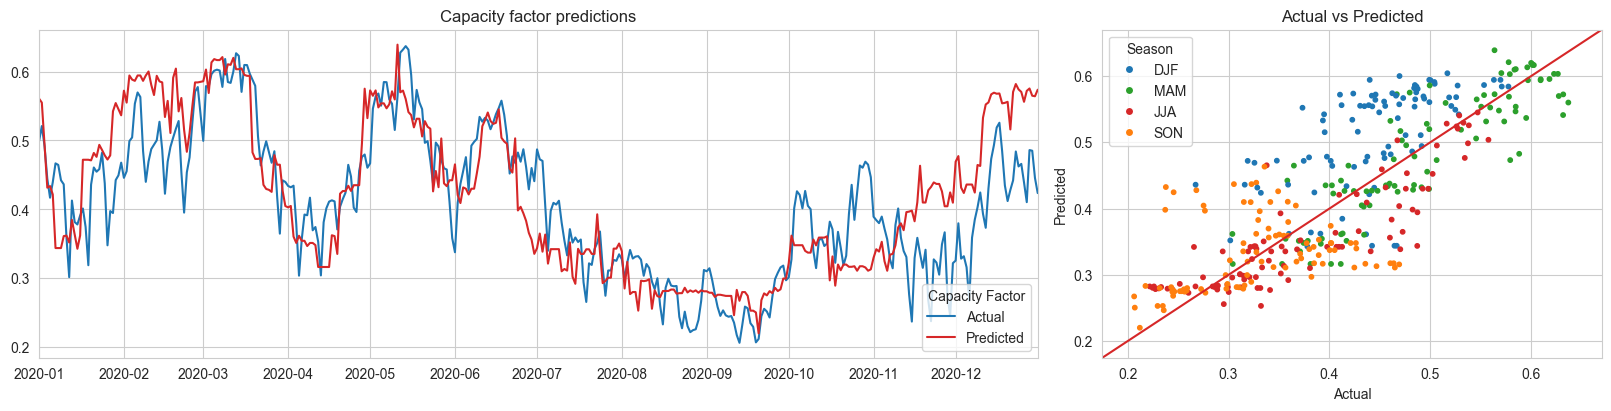

Split 6: Train=2190, Test=365, MSE=0.0046, R2=0.5629
R2: 0.459088
MSE: 0.007919



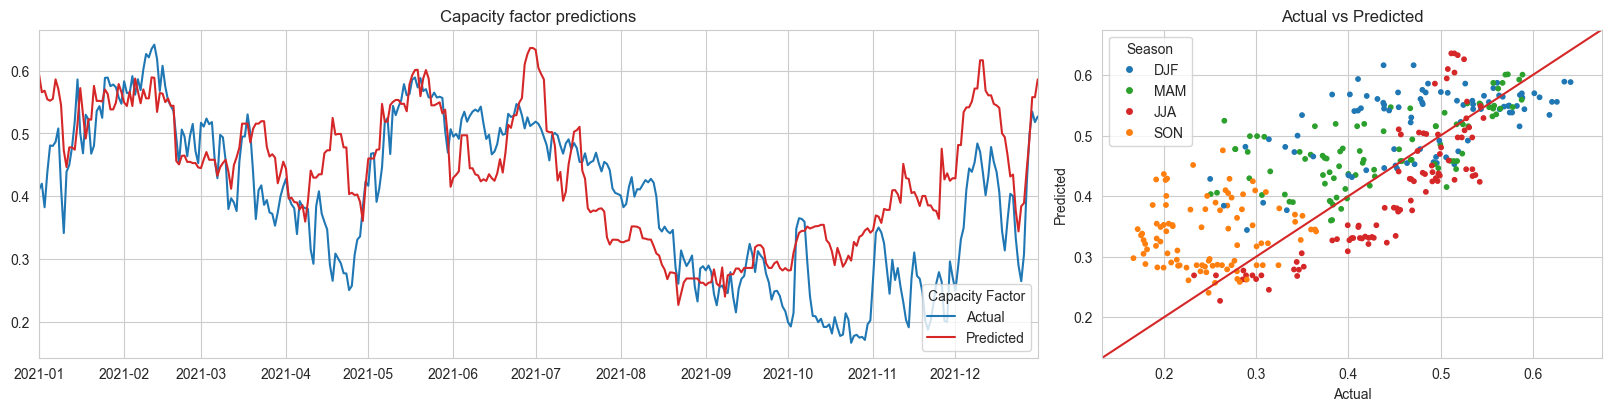

Split 7: Train=2555, Test=365, MSE=0.0079, R2=0.4591
R2: 0.069769
MSE: 0.009065



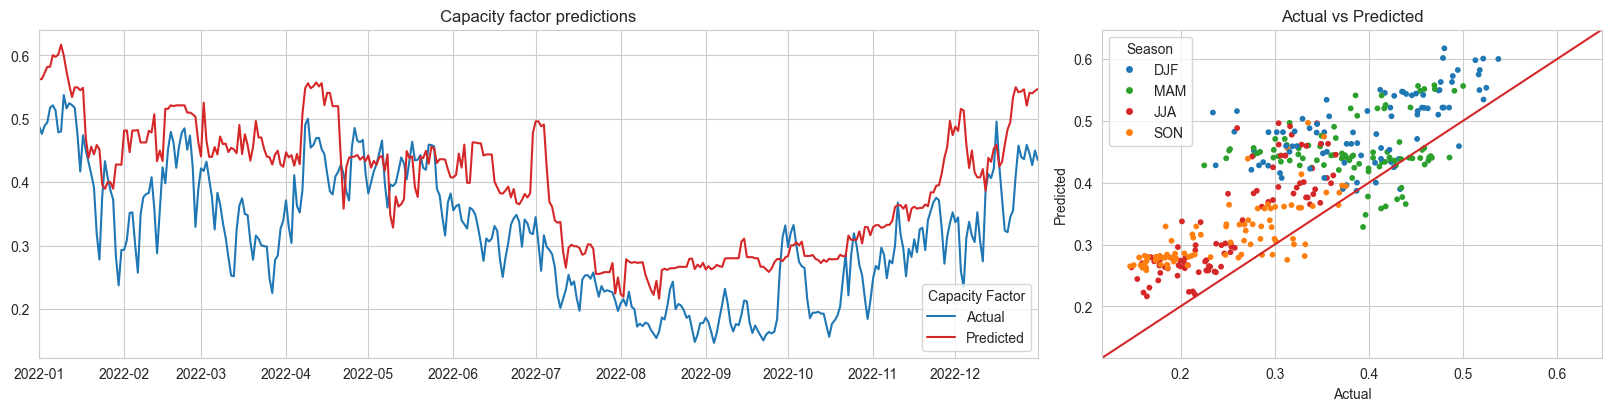

Split 8: Train=2920, Test=365, MSE=0.0091, R2=0.0698
R2: 0.392449
MSE: 0.006555



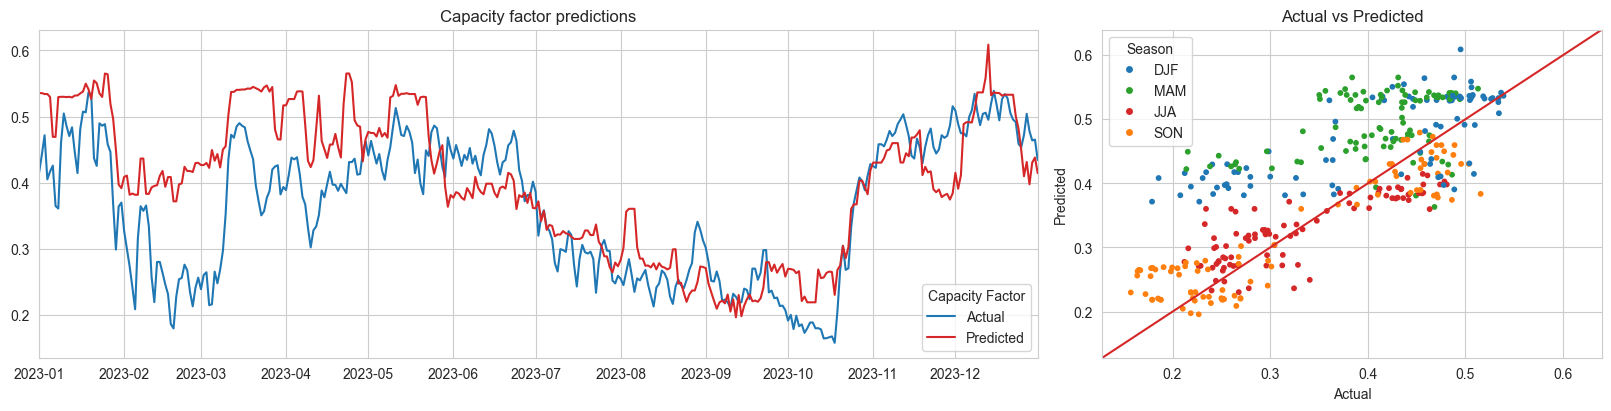

In [31]:
#ou avec 
from sklearn.model_selection import TimeSeriesSplit

tscv=TimeSeriesSplit(n_splits=8)
def display_result(y_true, y_pred):
    """Affiche les résultats de prédiction / réels."""
    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")

    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, color="tab:blue", s=10)

    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_ylim(lb, ub)
    ax2.set_xlim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    plt.show()
def display_result_season(y_true, y_pred):
    dmap = {
        12: 'DJF', 1: 'DJF', 2: 'DJF',
        3: 'MAM', 4: 'MAM', 5: 'MAM',
        6: 'JJA', 7: 'JJA', 8: 'JJA',
        9: 'SON', 10: 'SON', 11: 'SON'
    }
    cmap = {"DJF": "tab:blue", "MAM": "tab:green",
            "JJA": "tab:red", "SON": "tab:orange"}
    seasons = y_true.index.month.map(dmap)
    colors = seasons.map(cmap)

    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")
    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2 : 
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, c=colors, s=10)

    # Diagonale
    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_xlim(lb, ub)
    ax2.set_ylim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    # Légende
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=s, 
                   markerfacecolor=cmap[s], markersize=6)
        for s in ["DJF", "MAM", "JJA", "SON"]
    ]
    ax2.legend(handles=handles, title="Season")

    plt.show()
    
def time_split_cv(X, y, n_splits=8):
    """
    Génère des splits temporels pour la cross-validation.
    - n_splits : nombre de découpages"""
    tscv = TimeSeriesSplit(
    n_splits=n_splits)
    splits=[]
    for train_idx, test_idx in tscv.split(X):
        splits.append((train_idx, test_idx))
        
    return splits
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
gbr = GradientBoostingRegressor(
    n_estimators=300,   # nombre d’étapes de boosting
    learning_rate=0.05, # vitesse d'apprentissage
    max_depth=3,        # profondeur des arbres faibles
    random_state=40
)
gbr = GradientBoostingRegressor(
    n_estimators=300,   # nombre d’étapes de boosting
    learning_rate=0.05, # vitesse d'apprentissage
    max_depth=3,        # profondeur des arbres faibles
    random_state=40
)
results = []
model=LinearRegression()
rF=RandomForestRegressor(n_estimators=300)
for i, (train_idx, test_idx) in enumerate(time_split_cv(X2, y, n_splits=8)):
    # Découpage des données
    X_train, X_test = X2.iloc[train_idx], X2.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Entraînement
    gbr.fit(X_train, y_train)

    # Prédictions
    y_pred = gbr.predict(X_test)
    y_pred = pd.Series(y_pred, index=y_test.index)
    
    # Ajout dans results
    results.append({"split": i+1, "MSE": mse, "R2": r2})
    
    print(f"Split {i+1}: Train={len(train_idx)}, Test={len(test_idx)}, MSE={mse:.4f}, R2={r2:.4f}")
    
    # Métriques
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"R2: {r2:.06f}")
    print(f"MSE: {mse:.06f}")
    print()
    
    # Affichage personnalisé (même que ton code)
    display_result_season(y_test, y_pred)


In [ ]:
print(X)